# Funcioes Utiles

In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from cirq.circuits import InsertStrategy
# from cirq.contrib.svg import SVGCircuit #to print the circuit
# from cirq.contrib.svg import circuit_to_svg
import pandas as pd
import numpy as np
import sympy
import matplotlib.pyplot as plt
from cairosvg import svg2png
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.datasets import make_imbalance
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from utils_code import prepare_ZFeatureMap, QuantumConv, RealAmplitudes, prepare_ZZFeatureMap, plot_history_list

2023-03-12 03:25:26.443476: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-12 03:25:26.443514: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-12 03:25:30.414979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-12 03:25:30.415023: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-12 03:25:30.415054: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mac-desktop): /proc/driver/nvidia/version does not exist


In [2]:
#read_data = prepare_ZFeatureMap
#ansatz = RealAmplitudes
#classes = len(np.unique(y))
#nn =  tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
classes = x_train = x_test = y_train = y_test  = 0
#x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)
def Train_model_with(read_data= prepare_ZFeatureMap,
                     ansatz = RealAmplitudes, 
                     nn= tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')]),
                     epochs = 150,
                     model_times = 3,
                     data_splitted = (x_train, x_test, y_train, y_test ) ):
    (x_train, x_test, y_train, y_test ) = data_splitted
    x_train_q = [read_data(x,reps = 3) for x in x_train]
    x_test_q = [read_data(x,reps = 3) for x in x_test]
    model_circuit = ansatz(num_qubits=5, reps=10)#), qubits_out=3)
    circuit_input = tf.keras.Input(shape = (), dtype = tf.string, name = 'circuits_input')
    q = cirq.GridQubit.rect(1, 5)
    measurement_ops = [cirq.Z(q[i]) for i in range(5) ] 
    circuit_layer = tfq.layers.PQC(model_circuit, measurement_ops)


    model = tf.keras.Model(inputs = circuit_input, outputs = nn(circuit_layer(circuit_input)) )

    print(model.summary())
    list_models = []

    # metrics
    f1_list = []
    precision_list = []
    recall_list = []
    accuracy_list = []

    for i in range(model_times):
        model = tf.keras.Model(inputs = circuit_input, outputs = nn(circuit_layer(circuit_input)) )
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
        model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        history = model.fit(x = tfq.convert_to_tensor(x_train_q), y = y_train, epochs = epochs, verbose = 1, validation_data= (tfq.convert_to_tensor(x_test_q),y_test) )
        list_models.append(history)

        y_pred = model.predict(tfq.convert_to_tensor(x_test_q))
        f1_score = sklearn.metrics.f1_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
        precision_score = sklearn.metrics.precision_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
        recall_score = sklearn.metrics.recall_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
        accuracy_score = sklearn.metrics.accuracy_score(y_test.argmax( axis=1), y_pred.argmax( axis=1))
        f1_list.append( f1_score )
        precision_list.append( precision_score )
        recall_list.append( recall_score )
        accuracy_list.append( accuracy_score )

    plot_history_list(list_models,name="QNN Hybrid {}".format(name_dataset) )

    print("f1 :", f1_list)
    print("f1 average:", np.mean(f1_list) )
    print("Precision :", precision_list)
    print("precision average:", np.mean(precision_list) )
    print("Recall :", recall_list)
    print("recall average:", np.mean(recall_list) )
    print("Accuracy :", accuracy_list)
    print("accuracy average:", np.mean(accuracy_list) )
    model.evaluate(tfq.convert_to_tensor(x_test_q), y_test)
    cm = confusion_matrix(y_test.argmax( axis=1), y_pred.argmax( axis=1), normalize='true')

    if classes == 3:  
        ax = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['No Damage', 'Outer Ring', 'Inner Ring'],yticklabels=['No Damage', 'Outer Ring', 'Inner Ring'],)
    else:

        ax = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=range(classes),yticklabels=range(classes))
    
    ax.set_title('{} Confusion Matrix'.format(name_dataset));
    ax.set_xlabel('\nPredicted Label')
    ax.set_ylabel('True Label');
    #plt.savefig('/content/{}_CM.png'.format(name_dataset))
    plt.show()
    print("---------------------------------------------")
    print("---------------------------------------------")
    print("---------------------------------------------")

# Imports

In [3]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from cirq.circuits import InsertStrategy
# from cirq.contrib.svg import SVGCircuit #to print the circuit
# from cirq.contrib.svg import circuit_to_svg
import pandas as pd
import numpy as np
import sympy
import matplotlib.pyplot as plt
from cairosvg import svg2png
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.datasets import make_imbalance
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from utils_code import prepare_ZFeatureMap, QuantumConv, RealAmplitudes, prepare_ZZFeatureMap, plot_history_list

# CWRU - 3 Clases

In [4]:
!ls

content			   cwru_2.npz	      hol.py	  PU.ipynb
Create_model_cwru_3.ipynb  CWRU_3Classes.npz  mfpt_2.npz  __pycache__
Create_model.ipynb	   CWRU.ipynb	      myenv	  utils_code.py
Create_model_pu.ipynb	   CWRU_Quantum.npz   pu_2.npz


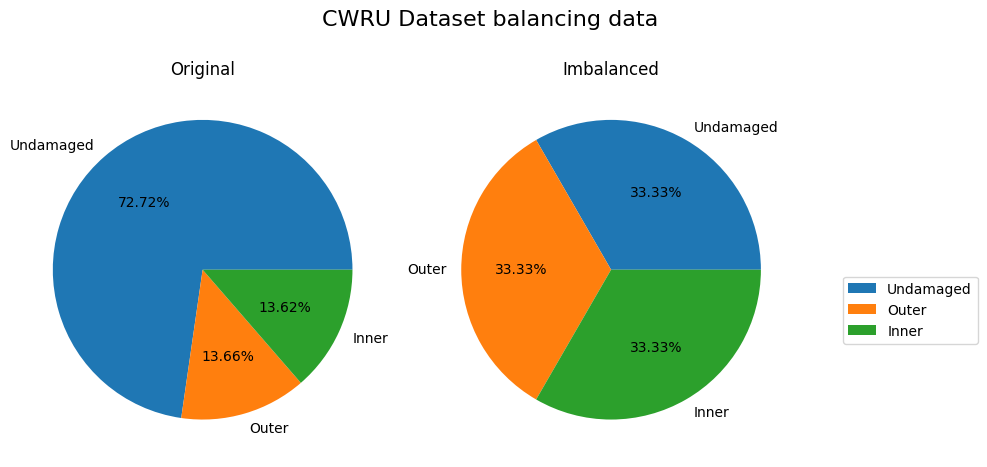

In [5]:
file_read = "CWRU_3Classes.npz"  #  pu_2.npz cwru_2.npz
name_dataset = "CWRU Dataset" #"PU", "CWRU"
data_load = np.load(file_read)
try:
  X, y = data_load["x"], data_load["y"]
except:
  X, y = data_load["data"], data_load["label"]


min_samples_label =  min([sum(y == i)  for i in range(3) ])
sampling_strategy = {0: min_samples_label, 
                     1: min_samples_label, 
                     2: min_samples_label}
X, y = make_imbalance(X, y, sampling_strategy=sampling_strategy)
X = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X)

labels = "Undamaged", "Outer", "Inner"
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
autopct = f"%.2f%%"
try:
    pd.DataFrame( data_load["y"]).value_counts().plot.pie(autopct=autopct, labels=labels, ax=axs[0], ylabel="")
except:
    pd.DataFrame( data_load["label"]).value_counts().plot.pie(autopct=autopct, labels=labels, ax=axs[0], ylabel="")
axs[0].set_title("Original")
pd.DataFrame( y ).value_counts().plot.pie(autopct=autopct, labels=labels,  ax=axs[1], ylabel="")
axs[1].set_title("Imbalanced")
plt.legend(labels,bbox_to_anchor=(1.1,0.5) )

fig.suptitle("{} balancing data".format(name_dataset), fontsize=16)
fig.tight_layout()

y = y.astype(int)
# Code a function to perform preprocessing on the classical dataset
def prepare_classic_dataset(X,y):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1)
    scaler = MinMaxScaler(feature_range = (0, np.pi))                                                  #o valor de cada característica é classificada como o angulo do qubit, portanto, em vez de normalizar entre 0 e 1, normalizamos entre 0 e pi
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)                                                                  #só o transform, se não vai contaminar os dados de teste
     
    classes = len(np.unique(y))

    y_train = np.eye(classes)[y_train]                                                                      #one hot encoder para otimizar, tem 3 características dos dados de treinamento (0, 1, 2 - modos de falha)
    y_test = np.eye(classes)[y_test]

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

Text(0.5, 1.0, 'CWRU Dataset')

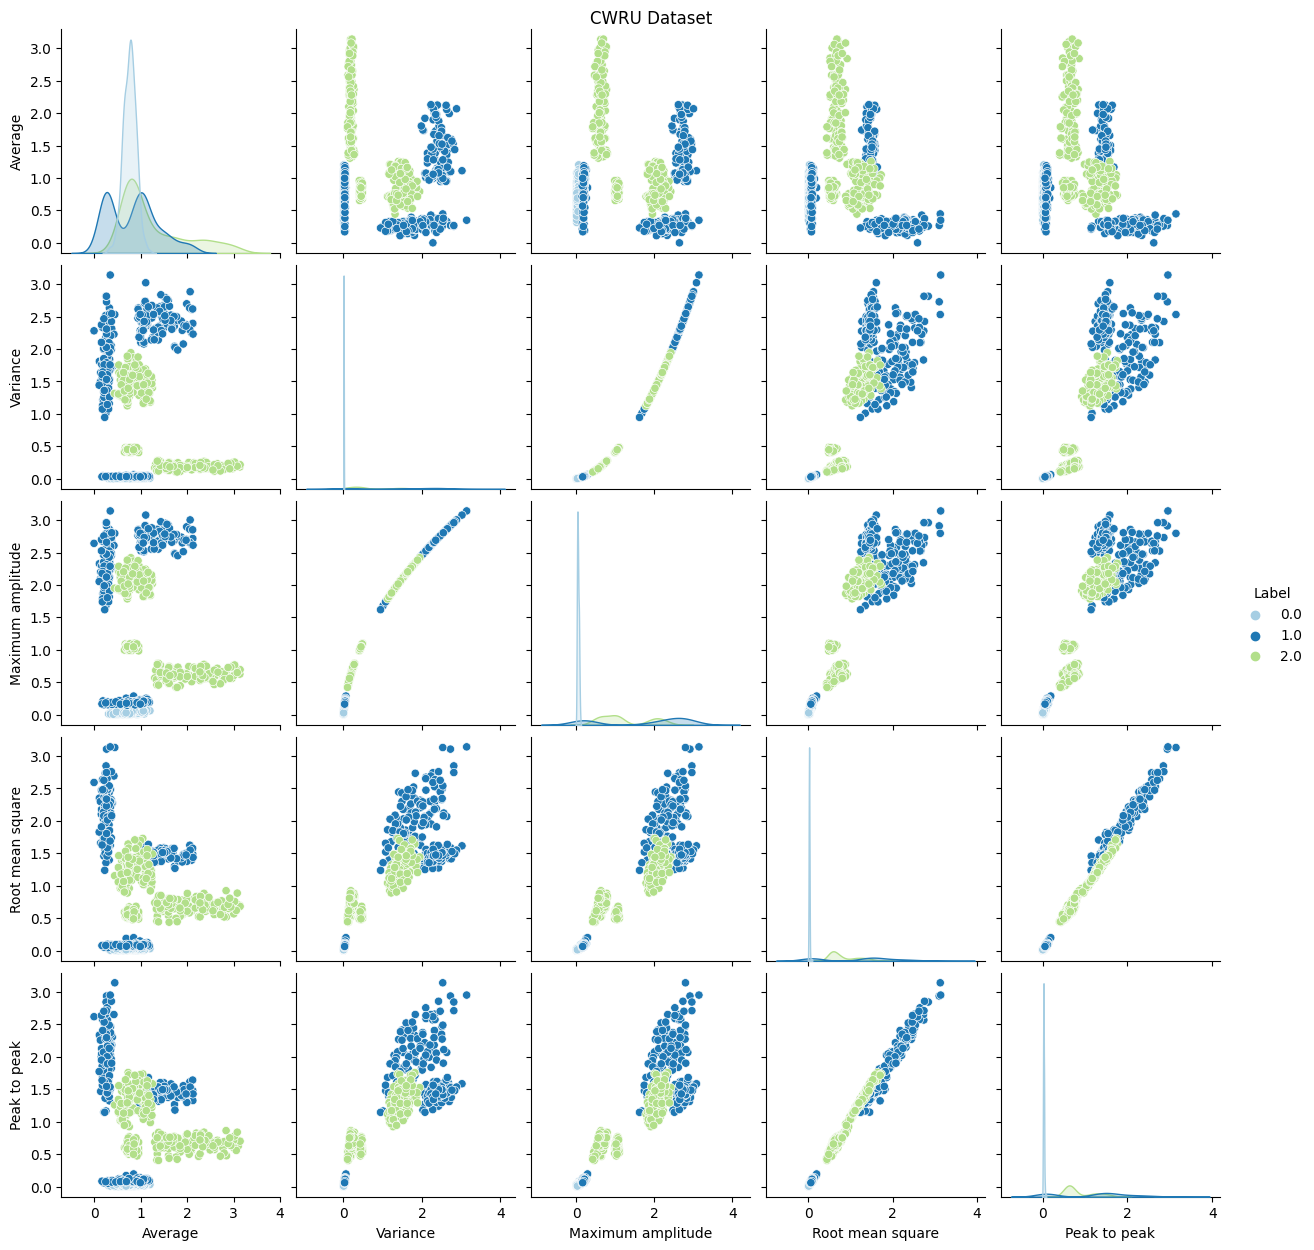

In [6]:
data_df = pd.DataFrame(np.hstack( ( X ,y.reshape(-1,1)) ), columns = ["Average","Variance","Maximum amplitude","Root mean square","Peak to peak","Label"])
p = sns.pairplot(data_df, hue = "Label", palette = "Paired")
p.fig.suptitle(name_dataset, y=1.0)

# Sin MLP

In [7]:
# Se crea una capa constante que es solo para seleccionar los 3 primeros qubits
class constant_layer(tf.keras.layers.Layer):
  def __init__(self):
    super(constant_layer, self).__init__()
  def build(self, input_shape):
    self.kernel =   tf.constant([[1,0,0],[0,1,0],[0,0,1],[0,0,0],[0,0,0]], dtype='float32')
  def call(self, inputs):
    return tf.matmul( inputs, self.kernel)
 
nn = tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc (PQC)                   (None, 5)                 55        
                                                                 
 sequential_2 (Sequential)   (None, 3)                 0         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
24/24 [==============================] - 7s 234ms/step - loss: 1.0124 - accuracy: 0.5369 - val_loss: 0.9130 - val_accuracy: 0.6406
Epoch 2/200
24/24 [==============================] - 5s 215ms/step - loss: 0.8806 - accuracy: 0.6403 - val_loss: 0.8459 - val_accuracy: 0.6938
Epoch 3/200
24/24 [===================

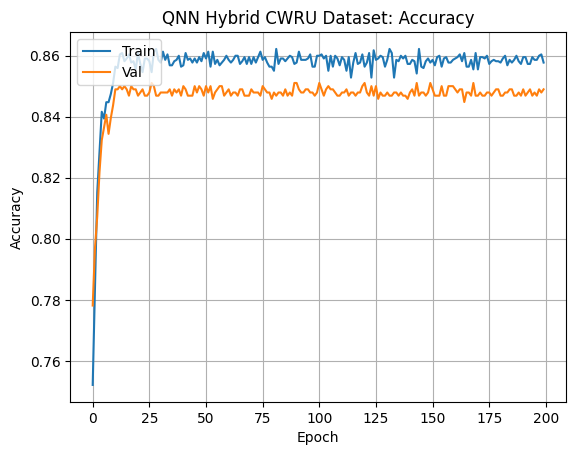

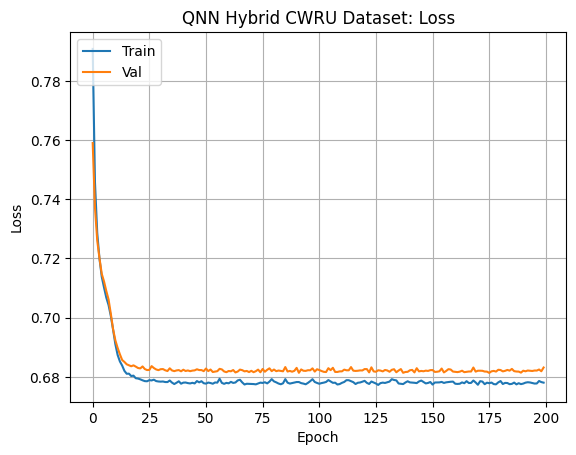

accuracy
[0.8617449402809143, 0.8550335764884949, 0.8563758134841919]
mean: 0.8577181100845337
devest: 0.0028996460831184783
val_accuracy
[0.8500000238418579, 0.846875011920929, 0.8500000238418579]
mean: 0.8489583532015482
devest: 0.0014731447470517757
loss
[0.6777560710906982, 0.6778855323791504, 0.6784199476242065]
mean: 0.6780205170313517
devest: 0.00028734260060444216
val_loss
[0.6827305555343628, 0.6822705864906311, 0.684394896030426]
mean: 0.68313201268514
devest: 0.000912523474820795
f1 : [0.85, 0.846875, 0.85]
f1 average: 0.8489583333333334
Precision : [0.85, 0.846875, 0.85]
precision average: 0.8489583333333334
Recall : [0.85, 0.846875, 0.85]
recall average: 0.8489583333333334
Accuracy : [0.85, 0.846875, 0.85]
accuracy average: 0.8489583333333334
10/10 [==============================] - 1s 107ms/step - loss: 0.6844 - accuracy: 0.8500


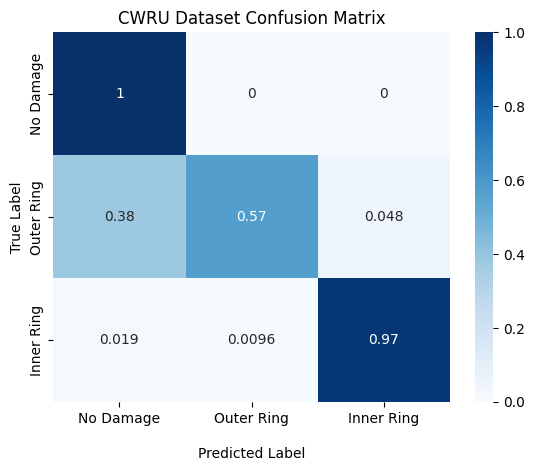

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [8]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn =  tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])
 #tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_1 (PQC)                 (None, 5)                 55        
                                                                 
 sequential_3 (Sequential)   (None, 3)                 0         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
24/24 [==============================] - 7s 275ms/step - loss: 1.0727 - accuracy: 0.4537 - val_loss: 0.9849 - val_accuracy: 0.5656
Epoch 2/200
24/24 [==============================] - 6s 265ms/step - loss: 0.9326 - accuracy: 0.6322 - val_loss: 0.8879 - val_accuracy: 0.6438
Epoch 3/200
24/24 [=================

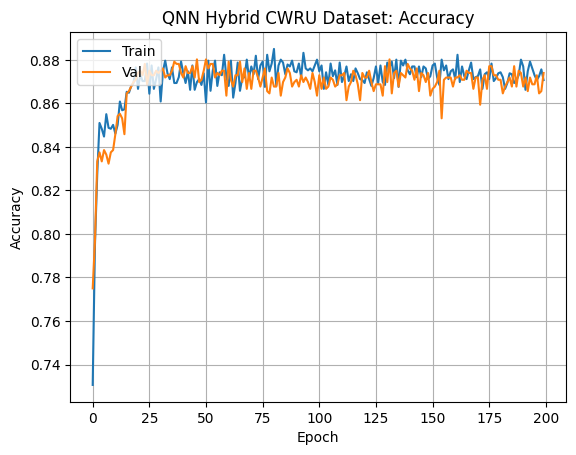

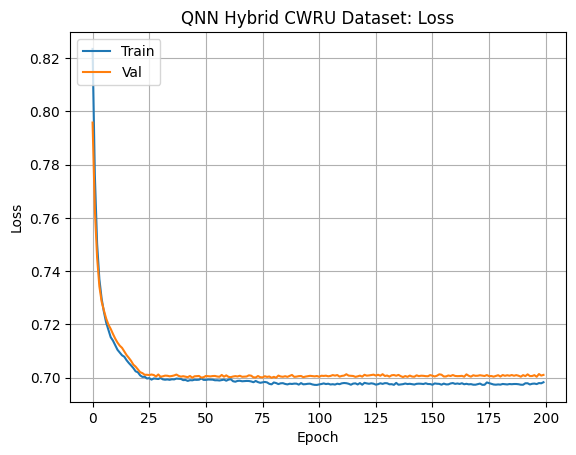

accuracy
[0.8751677870750427, 0.8724831938743591, 0.8644295334815979]
mean: 0.8706935048103333
devest: 0.004562876488116025
val_accuracy
[0.878125011920929, 0.8687499761581421, 0.875]
mean: 0.8739583293596903
devest: 0.0038975746459001498
loss
[0.6979483962059021, 0.699466347694397, 0.6974650621414185]
mean: 0.6982932686805725
devest: 0.0008526385455275877
val_loss
[0.7004917860031128, 0.7011505365371704, 0.7015083432197571]
mean: 0.7010502219200134
devest: 0.0004210260565882742
f1 : [0.878125, 0.86875, 0.875]
f1 average: 0.8739583333333334
Precision : [0.878125, 0.86875, 0.875]
precision average: 0.8739583333333334
Recall : [0.878125, 0.86875, 0.875]
recall average: 0.8739583333333334
Accuracy : [0.878125, 0.86875, 0.875]
accuracy average: 0.8739583333333334
10/10 [==============================] - 1s 139ms/step - loss: 0.7015 - accuracy: 0.8750


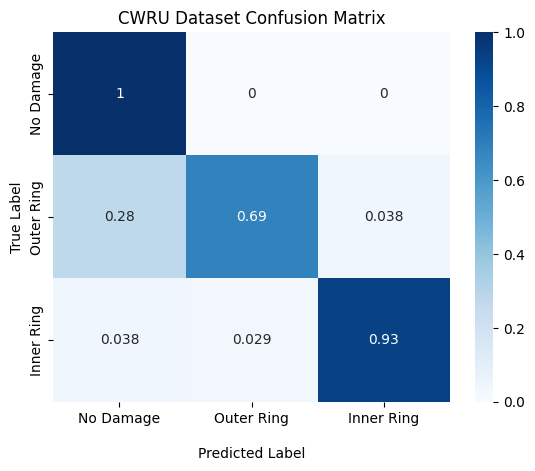

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [9]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn =  tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])
 #tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_2 (PQC)                 (None, 5)                 408       
                                                                 
 sequential_4 (Sequential)   (None, 3)                 0         
                                                                 
Total params: 408
Trainable params: 408
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
24/24 [==============================] - 47s 2s/step - loss: 0.8011 - accuracy: 0.7732 - val_loss: 0.6830 - val_accuracy: 0.8375
Epoch 2/200
24/24 [==============================] - 45s 2s/step - loss: 0.6560 - accuracy: 0.8564 - val_loss: 0.6355 - val_accuracy: 0.8531
Epoch 3/200
24/24 [===================

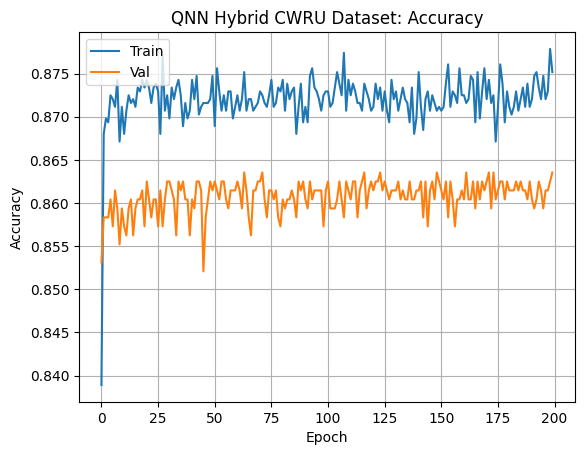

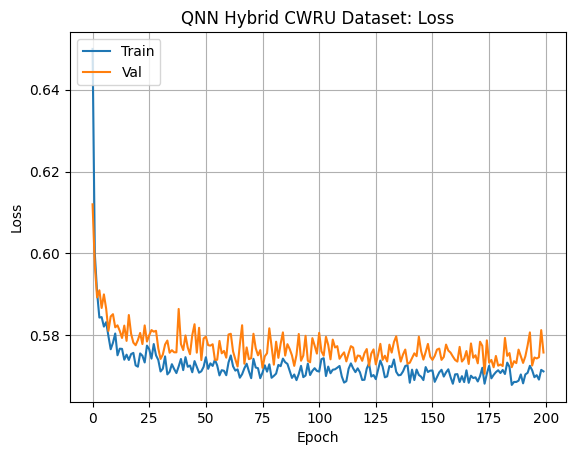

accuracy
[0.8724831938743591, 0.8765100836753845, 0.8765100836753845]
mean: 0.8751677870750427
devest: 0.0018982940569306672
val_accuracy
[0.862500011920929, 0.862500011920929, 0.8656250238418579]
mean: 0.8635416825612386
devest: 0.0014731447470517755
loss
[0.5727510452270508, 0.5692806243896484, 0.5714096426963806]
mean: 0.57114710410436
devest: 0.0014289040278932295
val_loss
[0.5758740305900574, 0.5792699456214905, 0.5721367597579956]
mean: 0.5757602453231812
devest: 0.0029132222087131566
f1 : [0.8625, 0.8625, 0.865625]
f1 average: 0.8635416666666668
Precision : [0.8625, 0.8625, 0.865625]
precision average: 0.8635416666666668
Recall : [0.8625, 0.8625, 0.865625]
recall average: 0.8635416666666668
Accuracy : [0.8625, 0.8625, 0.865625]
accuracy average: 0.8635416666666668
10/10 [==============================] - 9s 949ms/step - loss: 0.5721 - accuracy: 0.8656


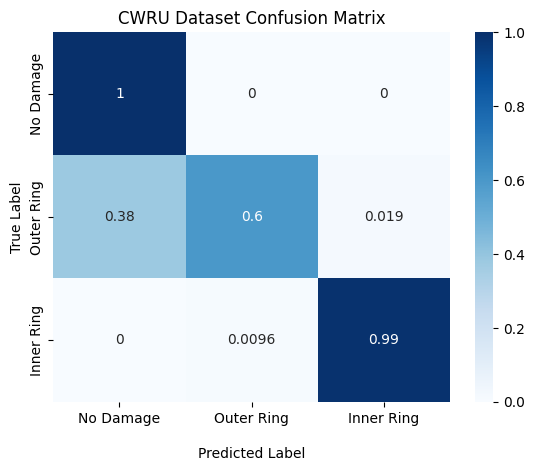

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [10]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn =  tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])
 #tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_3 (PQC)                 (None, 5)                 408       
                                                                 
 sequential_5 (Sequential)   (None, 3)                 0         
                                                                 
Total params: 408
Trainable params: 408
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
24/24 [==============================] - 47s 2s/step - loss: 0.7729 - accuracy: 0.7732 - val_loss: 0.6494 - val_accuracy: 0.9438
Epoch 2/200
24/24 [==============================] - 46s 2s/step - loss: 0.6149 - accuracy: 0.9409 - val_loss: 0.5850 - val_accuracy: 0.9344
Epoch 3/200
24/24 [==================

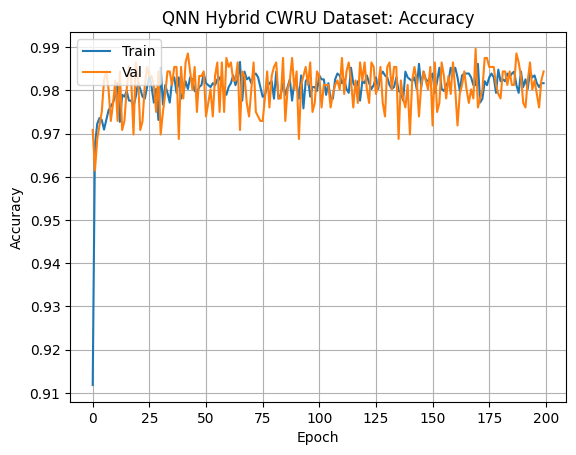

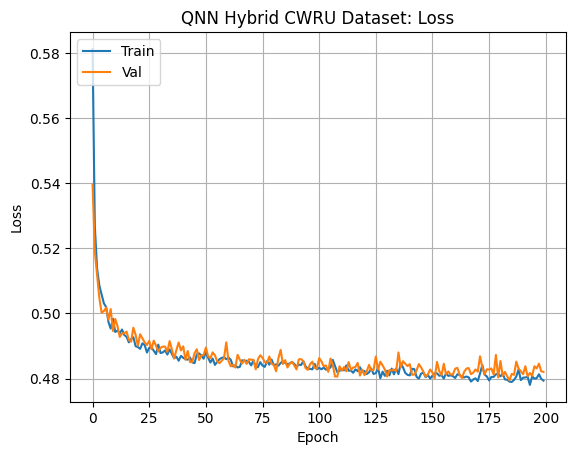

accuracy
[0.9812080264091492, 0.982550323009491, 0.9812080264091492]
mean: 0.9816554586092631
devest: 0.0006327646856435557
val_accuracy
[0.984375, 0.9906250238418579, 0.9781249761581421]
mean: 0.984375
devest: 0.0051031230975937545
loss
[0.4794948101043701, 0.4791082441806793, 0.4794294238090515]
mean: 0.4793441593647003
devest: 0.0001689394811613876
val_loss
[0.478583961725235, 0.48419269919395447, 0.4833347201347351]
mean: 0.48203712701797485
devest: 0.0024667515644064024
f1 : [0.984375, 0.990625, 0.978125]
f1 average: 0.984375
Precision : [0.984375, 0.990625, 0.978125]
precision average: 0.984375
Recall : [0.984375, 0.990625, 0.978125]
recall average: 0.984375
Accuracy : [0.984375, 0.990625, 0.978125]
accuracy average: 0.984375
10/10 [==============================] - 10s 977ms/step - loss: 0.4833 - accuracy: 0.9781


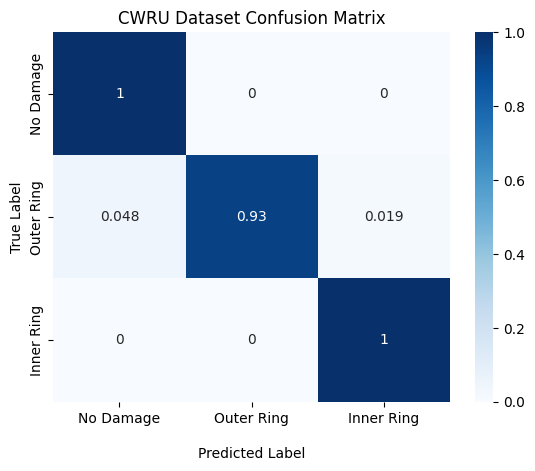

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [11]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn =  tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])
 #tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

# CON MLP

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_4 (PQC)                 (None, 5)                 55        
                                                                 
 sequential_6 (Sequential)   (None, 3)                 903       
                                                                 
Total params: 958
Trainable params: 958
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
24/24 [==============================] - 7s 236ms/step - loss: 0.7020 - accuracy: 0.7087 - val_loss: 0.4015 - val_accuracy: 0.8375
Epoch 2/200
24/24 [==============================] - 6s 241ms/step - loss: 0.3211 - accuracy: 0.8738 - val_loss: 0.2638 - val_accuracy: 0.8625
Epoch 3/200
24/24 [==============

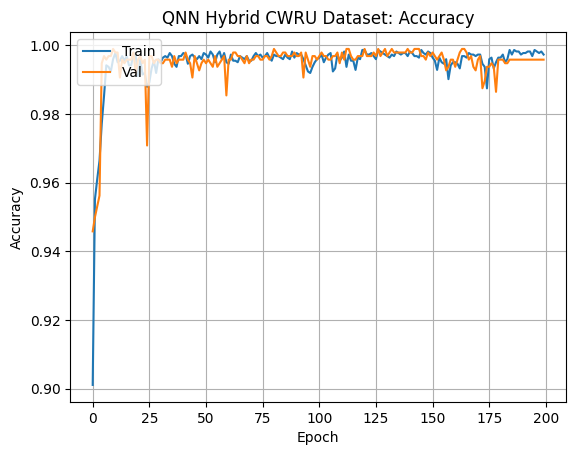

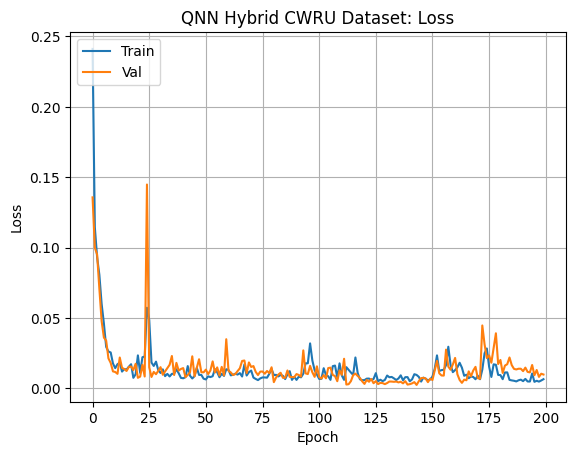

accuracy
[0.9959731698036194, 0.9973154067993164, 0.9986577033996582]
mean: 0.9973154266675314
devest: 0.0010959562513657003
val_accuracy
[0.9937499761581421, 0.9937499761581421, 1.0]
mean: 0.9958333174387614
devest: 0.002946289494103551
loss
[0.01158076524734497, 0.00467794481664896, 0.003058924339711666]
mean: 0.006439211467901866
devest: 0.003695221082818981
val_loss
[0.0158100463449955, 0.013402136974036694, 5.950061677140184e-05]
mean: 0.009757227978601199
devest: 0.006927430686431756
f1 : [0.99375, 0.99375, 1.0]
f1 average: 0.9958333333333332
Precision : [0.99375, 0.99375, 1.0]
precision average: 0.9958333333333332
Recall : [0.99375, 0.99375, 1.0]
recall average: 0.9958333333333332
Accuracy : [0.99375, 0.99375, 1.0]
accuracy average: 0.9958333333333332
10/10 [==============================] - 1s 104ms/step - loss: 5.9501e-05 - accuracy: 1.0000


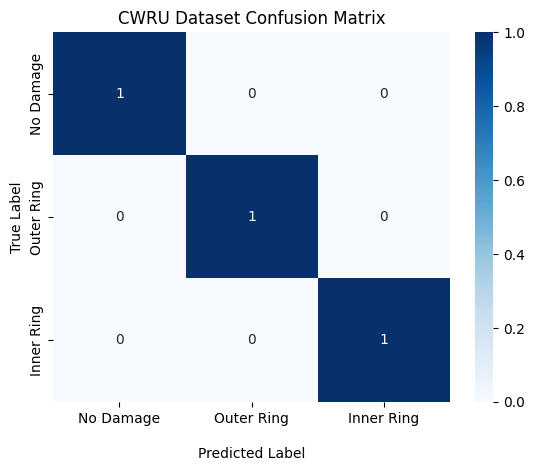

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [12]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_5 (PQC)                 (None, 5)                 55        
                                                                 
 sequential_7 (Sequential)   (None, 3)                 903       
                                                                 
Total params: 958
Trainable params: 958
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
24/24 [==============================] - 8s 290ms/step - loss: 0.7746 - accuracy: 0.7544 - val_loss: 0.3632 - val_accuracy: 0.8750
Epoch 2/200
24/24 [==============================] - 7s 295ms/step - loss: 0.2323 - accuracy: 0.9302 - val_loss: 0.1690 - val_accuracy: 0.9344
Epoch 3/200
24/24 [==============

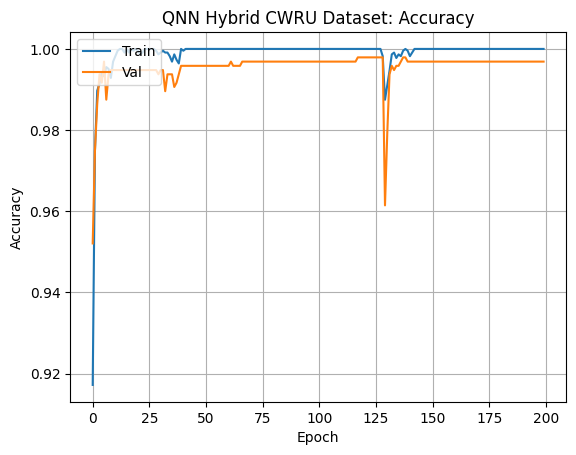

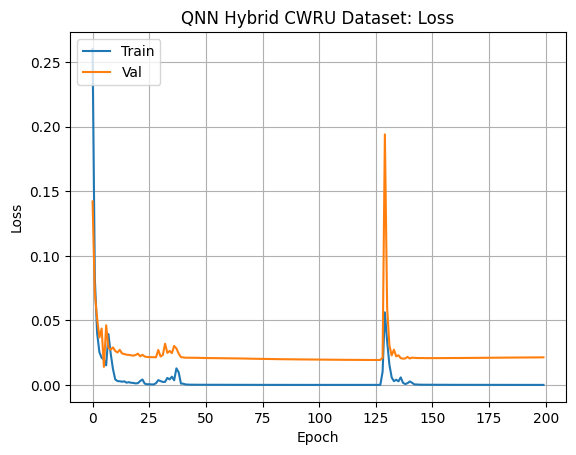

accuracy
[1.0, 1.0, 1.0]
mean: 1.0
devest: 0.0
val_accuracy
[0.996874988079071, 0.996874988079071, 0.996874988079071]
mean: 0.996874988079071
devest: 0.0
loss
[9.202163346344605e-05, 7.539700277447992e-07, 5.097957682664855e-07]
mean: 3.109513308648578e-05
devest: 4.308165689637183e-05
val_loss
[0.007736177649348974, 0.023599177598953247, 0.03283752128481865]
mean: 0.021390958844373625
devest: 0.010365858563172384
f1 : [0.996875, 0.996875, 0.996875]
f1 average: 0.9968749999999998
Precision : [0.996875, 0.996875, 0.996875]
precision average: 0.9968749999999998
Recall : [0.996875, 0.996875, 0.996875]
recall average: 0.9968749999999998
Accuracy : [0.996875, 0.996875, 0.996875]
accuracy average: 0.9968749999999998
10/10 [==============================] - 1s 137ms/step - loss: 0.0328 - accuracy: 0.9969


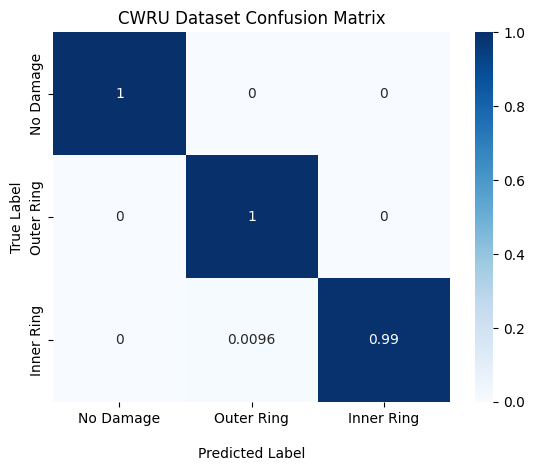

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [13]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_6 (PQC)                 (None, 5)                 408       
                                                                 
 sequential_8 (Sequential)   (None, 3)                 903       
                                                                 
Total params: 1,311
Trainable params: 1,311
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
24/24 [==============================] - 47s 2s/step - loss: 0.5589 - accuracy: 0.7946 - val_loss: 0.2894 - val_accuracy: 0.8719
Epoch 2/200
24/24 [==============================] - 46s 2s/step - loss: 0.2295 - accuracy: 0.9074 - val_loss: 0.1145 - val_accuracy: 0.9937
Epoch 3/200
24/24 [==============

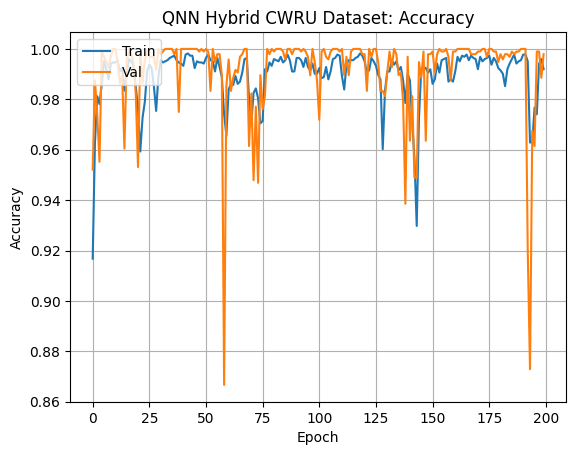

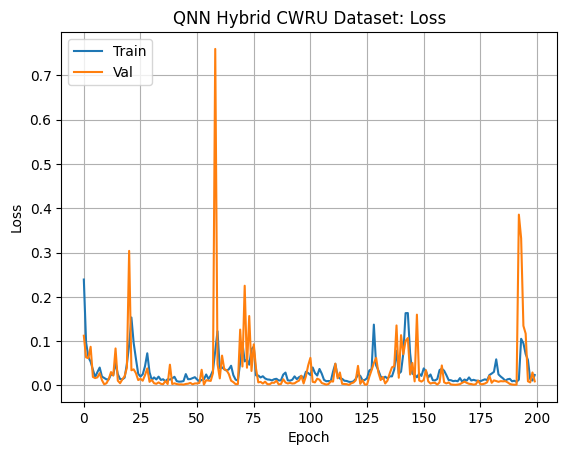

accuracy
[0.991946280002594, 0.9973154067993164, 0.9865771532058716]
mean: 0.991946280002594
devest: 0.004383873672091284
val_accuracy
[0.9937499761581421, 1.0, 1.0]
mean: 0.9979166587193807
devest: 0.002946289494103551
loss
[0.021445078775286674, 0.01646587997674942, 0.0321321003139019]
mean: 0.023347686355312664
devest: 0.006535673982879488
val_loss
[0.02271558716893196, 0.0016528696287423372, 0.0027876091189682484]
mean: 0.009052021972214183
devest: 0.009672699342010226
f1 : [0.99375, 1.0, 1.0]
f1 average: 0.9979166666666667
Precision : [0.99375, 1.0, 1.0]
precision average: 0.9979166666666667
Recall : [0.99375, 1.0, 1.0]
recall average: 0.9979166666666667
Accuracy : [0.99375, 1.0, 1.0]
accuracy average: 0.9979166666666667
10/10 [==============================] - 9s 929ms/step - loss: 0.0028 - accuracy: 1.0000


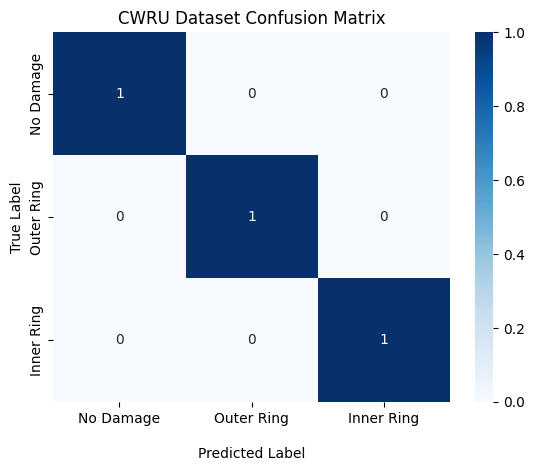

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [14]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_7 (PQC)                 (None, 5)                 408       
                                                                 
 sequential_9 (Sequential)   (None, 3)                 903       
                                                                 
Total params: 1,311
Trainable params: 1,311
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
24/24 [==============================] - 48s 2s/step - loss: 0.5416 - accuracy: 0.8255 - val_loss: 0.0617 - val_accuracy: 0.9969
Epoch 2/200
24/24 [==============================] - 47s 2s/step - loss: 0.0399 - accuracy: 0.9919 - val_loss: 0.0116 - val_accuracy: 0.9969
Epoch 3/200
24/24 [==============

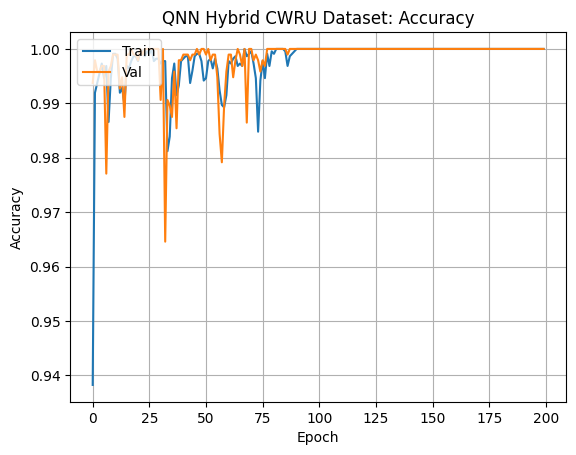

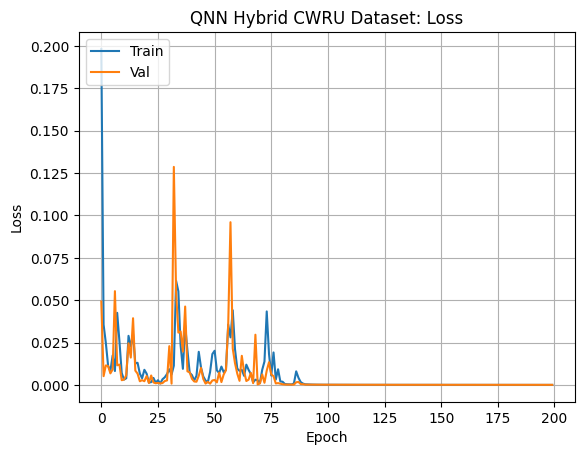

accuracy
[1.0, 1.0, 1.0]
mean: 1.0
devest: 0.0
val_accuracy
[1.0, 1.0, 1.0]
mean: 1.0
devest: 0.0
loss
[1.4102593922871165e-05, 6.9727489062643144e-06, 7.785048182995524e-06]
mean: 9.620130337377e-06
devest: 3.1868811687087224e-06
val_loss
[3.0653620342491195e-05, 7.605305290780962e-05, 7.203617133200169e-05]
mean: 5.9580948194100834e-05
devest: 2.052034042723462e-05
f1 : [1.0, 1.0, 1.0]
f1 average: 1.0
Precision : [1.0, 1.0, 1.0]
precision average: 1.0
Recall : [1.0, 1.0, 1.0]
recall average: 1.0
Accuracy : [1.0, 1.0, 1.0]
accuracy average: 1.0
10/10 [==============================] - 10s 1s/step - loss: 7.2036e-05 - accuracy: 1.0000


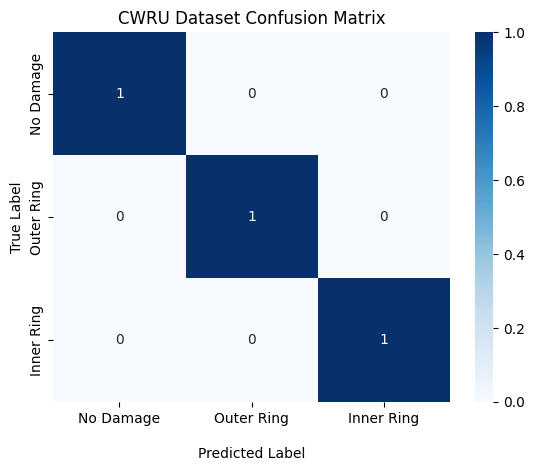

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [15]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 200,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

# Comparación de modelos - 10 Clases

In [16]:
file_read = "CWRU_Quantum.npz"  #  pu_2.npz cwru_2.npz
name_dataset = "CWRU Dataset 10 Clases" #"PU", "CWRU"
data_load = np.load(file_read)
X, y = data_load["data"], data_load["label"]

y = y.astype(int)
# Code a function to perform preprocessing on the classical dataset
def prepare_classic_dataset(X,y):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1)
    scaler = MinMaxScaler(feature_range = (0, np.pi))                                                  #o valor de cada característica é classificada como o angulo do qubit, portanto, em vez de normalizar entre 0 e 1, normalizamos entre 0 e pi
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)                                                                  #só o transform, se não vai contaminar os dados de teste
     
    classes = len(np.unique(y))

    y_train = np.eye(classes)[y_train]                                                                      #one hot encoder para otimizar, tem 3 características dos dados de treinamento (0, 1, 2 - modos de falha)
    y_test = np.eye(classes)[y_test]

    return x_train, x_test, y_train, y_test
    
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_8 (PQC)                 (None, 5)                 55        
                                                                 
 sequential_11 (Sequential)  (None, 10)                1610      
                                                                 
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
29/29 [==============================] - 7s 223ms/step - loss: 1.8273 - accuracy: 0.3855 - val_loss: 1.2465 - val_accuracy: 0.7015
Epoch 2/150
29/29 [==============================] - 6s 224ms/step - loss: 0.9317 - accuracy: 0.6966 - val_loss: 0.6582 - val_accuracy: 0.7908
Epoch 3/150
29/29 [==========

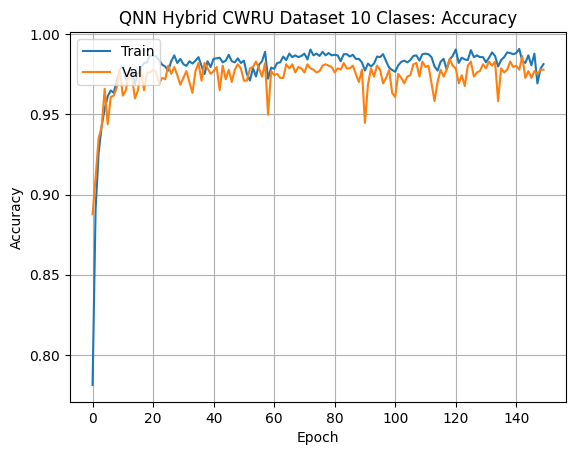

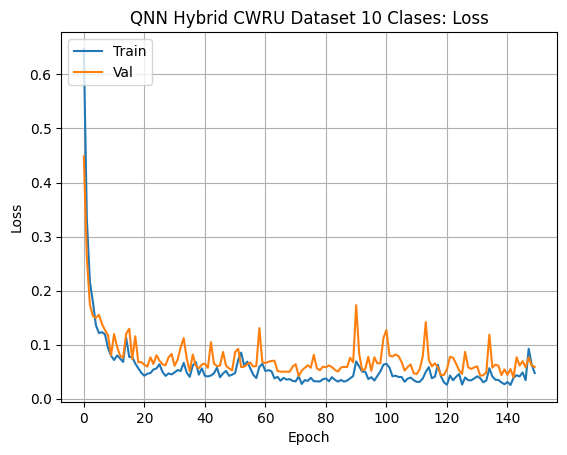

accuracy
[0.978094220161438, 0.989047110080719, 0.9769989252090454]
mean: 0.9813800851504008
devest: 0.005439814409810609
val_accuracy
[0.9744898080825806, 0.9770408272743225, 0.9821428656578064]
mean: 0.9778911670049032
devest: 0.0031816799341944438
loss
[0.06162270903587341, 0.020578213036060333, 0.05992453917860985]
mean: 0.0473751537501812
devest: 0.018960976925308307
val_loss
[0.07466906309127808, 0.0625576451420784, 0.039224959909915924]
mean: 0.05881722271442413
devest: 0.014709728810909147
f1 : [0.9744897959183674, 0.9770408163265306, 0.9821428571428571]
f1 average: 0.9778911564625851
Precision : [0.9744897959183674, 0.9770408163265306, 0.9821428571428571]
precision average: 0.9778911564625851
Recall : [0.9744897959183674, 0.9770408163265306, 0.9821428571428571]
recall average: 0.9778911564625851
Accuracy : [0.9744897959183674, 0.9770408163265306, 0.9821428571428571]
accuracy average: 0.9778911564625851
13/13 [==============================] - 2s 119ms/step - loss: 0.0392 - acc

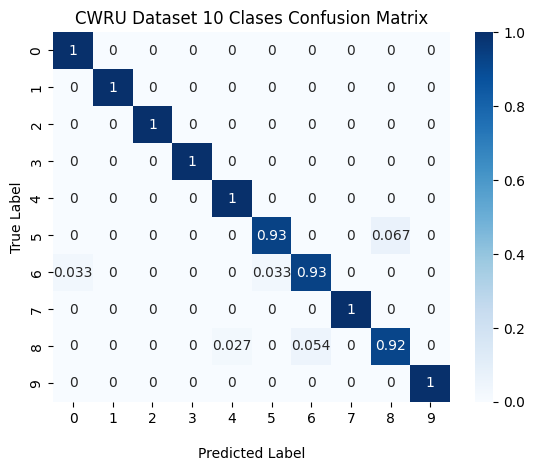

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [17]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn =  tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= prepare_ZFeatureMap,
                ansatz = RealAmplitudes, 
                nn= tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')]),
                epochs = 150,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_9 (PQC)                 (None, 5)                 55        
                                                                 
 sequential_12 (Sequential)  (None, 10)                1610      
                                                                 
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
29/29 [==============================] - 8s 235ms/step - loss: 1.7321 - accuracy: 0.4524 - val_loss: 1.1427 - val_accuracy: 0.5969
Epoch 2/150
29/29 [==============================] - 7s 229ms/step - loss: 0.9222 - accuracy: 0.6889 - val_loss: 0.6959 - val_accuracy: 0.8291
Epoch 3/150
29/29 [==========

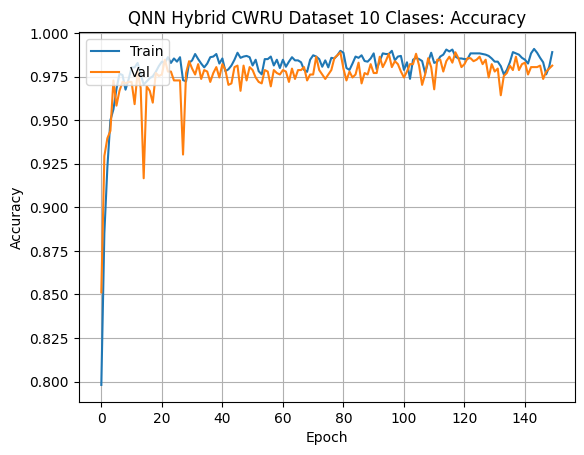

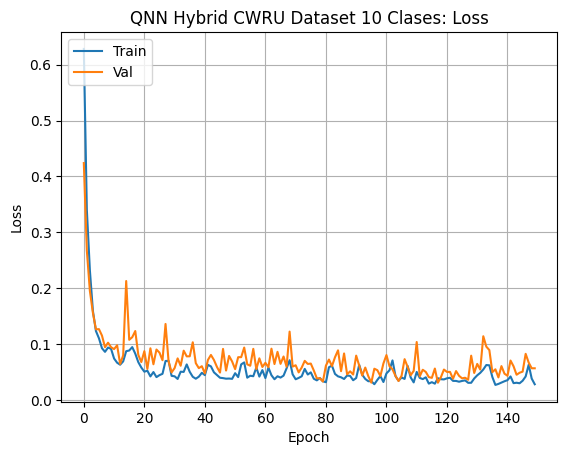

accuracy
[0.9857612252235413, 0.9912376999855042, 0.9901424050331116]
mean: 0.989047110080719
devest: 0.002366107524910427
val_accuracy
[0.9821428656578064, 0.9846938848495483, 0.9770408272743225]
mean: 0.9812925259272257
devest: 0.0031816799341944438
loss
[0.03772472217679024, 0.02435077354311943, 0.021881256252527237]
mean: 0.0279855839908123
devest: 0.006960016205264355
val_loss
[0.06169518828392029, 0.047271743416786194, 0.06064693257212639]
mean: 0.056537954757610955
devest: 0.0065661614595311935
f1 : [0.9821428571428571, 0.9846938775510204, 0.9770408163265306]
f1 average: 0.9812925170068026
Precision : [0.9821428571428571, 0.9846938775510204, 0.9770408163265306]
precision average: 0.9812925170068026
Recall : [0.9821428571428571, 0.9846938775510204, 0.9770408163265306]
recall average: 0.9812925170068026
Accuracy : [0.9821428571428571, 0.9846938775510204, 0.9770408163265306]
accuracy average: 0.9812925170068026
13/13 [==============================] - 1s 111ms/step - loss: 0.0606 -

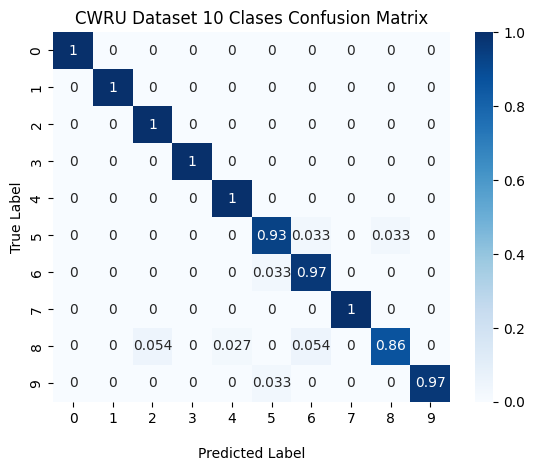

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [18]:
read_data = prepare_ZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn =  tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 150,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_10 (PQC)                (None, 5)                 55        
                                                                 
 sequential_13 (Sequential)  (None, 10)                1610      
                                                                 
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
29/29 [==============================] - 9s 304ms/step - loss: 1.7477 - accuracy: 0.4666 - val_loss: 1.1588 - val_accuracy: 0.6301
Epoch 2/150
29/29 [==============================] - 9s 299ms/step - loss: 0.8475 - accuracy: 0.7284 - val_loss: 0.7123 - val_accuracy: 0.7577
Epoch 3/150
29/29 [==========

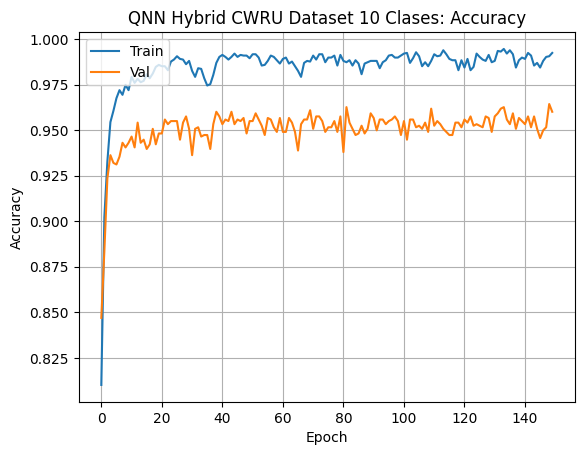

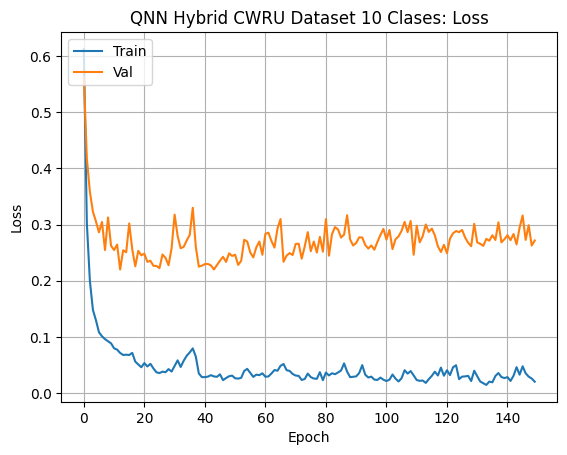

accuracy
[0.989047110080719, 0.9945235252380371, 0.9934282302856445]
mean: 0.9923329552014669
devest: 0.0023660799333272992
val_accuracy
[0.9617347121238708, 0.956632673740387, 0.9617347121238708]
mean: 0.9600340326627096
devest: 0.0024051239592236713
loss
[0.02601894550025463, 0.016804659739136696, 0.017465466633439064]
mean: 0.020096357290943462
devest: 0.004196582320626562
val_loss
[0.21641910076141357, 0.287631094455719, 0.3108113706111908]
mean: 0.2716205219427745
devest: 0.04016407163948464
f1 : [0.9617346938775511, 0.9566326530612245, 0.9617346938775511]
f1 average: 0.960034013605442
Precision : [0.9617346938775511, 0.9566326530612245, 0.9617346938775511]
precision average: 0.960034013605442
Recall : [0.9617346938775511, 0.9566326530612245, 0.9617346938775511]
recall average: 0.960034013605442
Accuracy : [0.9617346938775511, 0.9566326530612245, 0.9617346938775511]
accuracy average: 0.960034013605442
13/13 [==============================] - 1s 103ms/step - loss: 0.3108 - accuracy

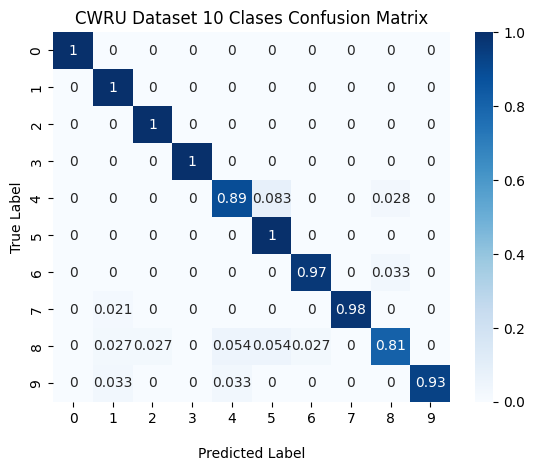

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [19]:

read_data = prepare_ZZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn =  tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 150,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_11 (PQC)                (None, 5)                 408       
                                                                 
 sequential_14 (Sequential)  (None, 10)                1610      
                                                                 
Total params: 2,018
Trainable params: 2,018
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
29/29 [==============================] - 50s 2s/step - loss: 1.6925 - accuracy: 0.3943 - val_loss: 1.0037 - val_accuracy: 0.6786
Epoch 2/150
29/29 [==============================] - 50s 2s/step - loss: 0.7746 - accuracy: 0.7382 - val_loss: 0.4950 - val_accuracy: 0.8546
Epoch 3/150
29/29 [==============

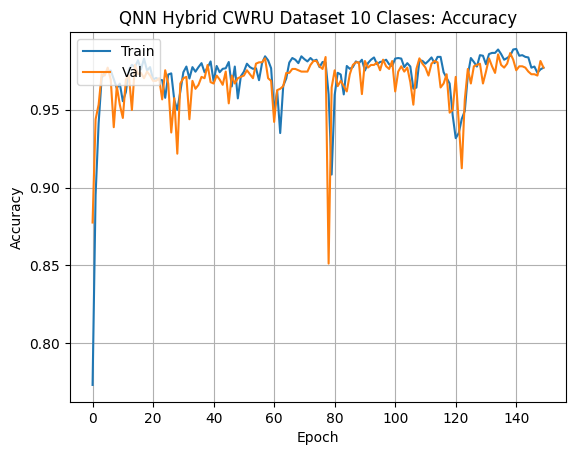

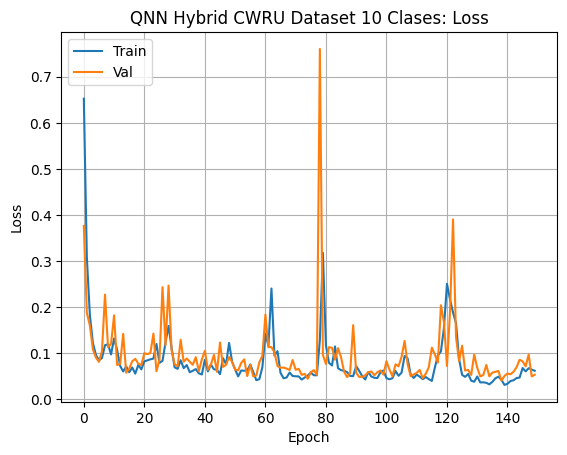

accuracy
[0.9748083353042603, 0.9791894555091858, 0.9769989252090454]
mean: 0.9769989053408304
devest: 0.0017885848340327155
val_accuracy
[0.9821428656578064, 0.9846938848495483, 0.9642857313156128]
mean: 0.9770408272743225
devest: 0.009079143844220799
loss
[0.06414511054754257, 0.04673711583018303, 0.07536404579877853]
mean: 0.06208209072550138
devest: 0.011777586565062725
val_loss
[0.04201870039105415, 0.044997185468673706, 0.07350816577672958]
mean: 0.05350801721215248
devest: 0.014194419097971034
f1 : [0.9821428571428571, 0.9846938775510204, 0.9642857142857143]
f1 average: 0.9770408163265306
Precision : [0.9821428571428571, 0.9846938775510204, 0.9642857142857143]
precision average: 0.9770408163265306
Recall : [0.9821428571428571, 0.9846938775510204, 0.9642857142857143]
recall average: 0.9770408163265306
Accuracy : [0.9821428571428571, 0.9846938775510204, 0.9642857142857143]
accuracy average: 0.9770408163265306
13/13 [==============================] - 10s 749ms/step - loss: 0.0735 -

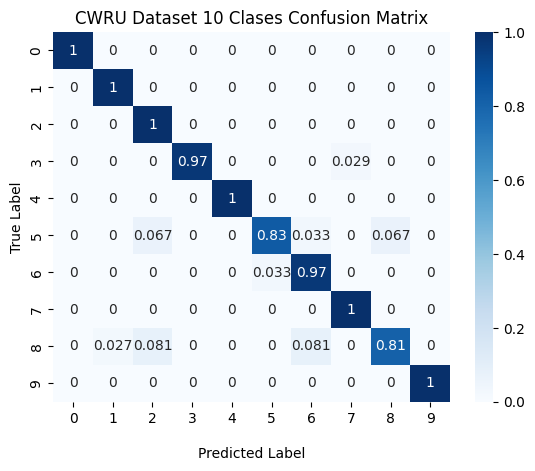

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [20]:
read_data = prepare_ZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn =  tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 150,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_12 (PQC)                (None, 5)                 408       
                                                                 
 sequential_15 (Sequential)  (None, 10)                1610      
                                                                 
Total params: 2,018
Trainable params: 2,018
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
29/29 [==============================] - 53s 2s/step - loss: 1.6181 - accuracy: 0.4929 - val_loss: 0.8344 - val_accuracy: 0.7602
Epoch 2/150
29/29 [==============================] - 53s 2s/step - loss: 0.4702 - accuracy: 0.9102 - val_loss: 0.3084 - val_accuracy: 0.9439
Epoch 3/150
29/29 [==============

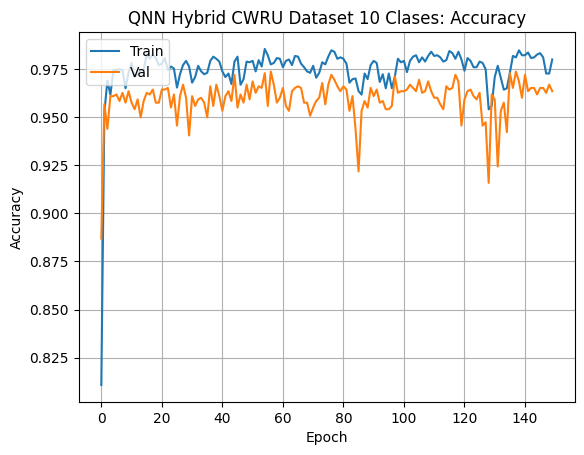

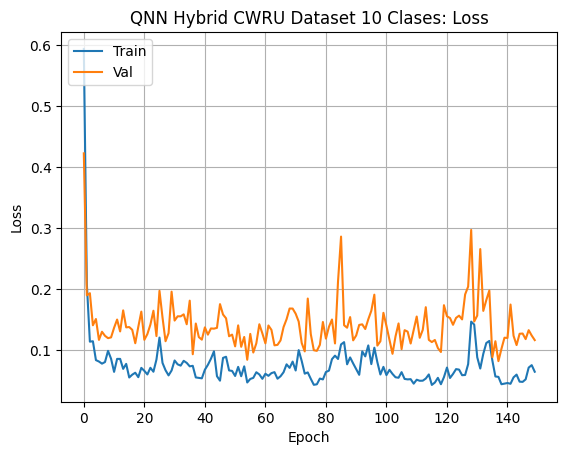

accuracy
[0.9769989252090454, 0.9857612252235413, 0.9769989252090454]
mean: 0.9799196918805441
devest: 0.004130587839360666
val_accuracy
[0.9617347121238708, 0.9744898080825806, 0.954081654548645]
mean: 0.9634353915850321
devest: 0.00841793385728285
loss
[0.0759178102016449, 0.0358133502304554, 0.08130709081888199]
mean: 0.06434608375032742
devest: 0.020295299094122813
val_loss
[0.09573793411254883, 0.0914304330945015, 0.16159513592720032]
mean: 0.11625450104475021
devest: 0.03210886191186537
f1 : [0.9617346938775511, 0.9744897959183674, 0.9540816326530612]
f1 average: 0.9634353741496599
Precision : [0.9617346938775511, 0.9744897959183674, 0.9540816326530612]
precision average: 0.9634353741496599
Recall : [0.9617346938775511, 0.9744897959183674, 0.9540816326530612]
recall average: 0.9634353741496599
Accuracy : [0.9617346938775511, 0.9744897959183674, 0.9540816326530612]
accuracy average: 0.9634353741496599
13/13 [==============================] - 10s 777ms/step - loss: 0.1616 - accurac

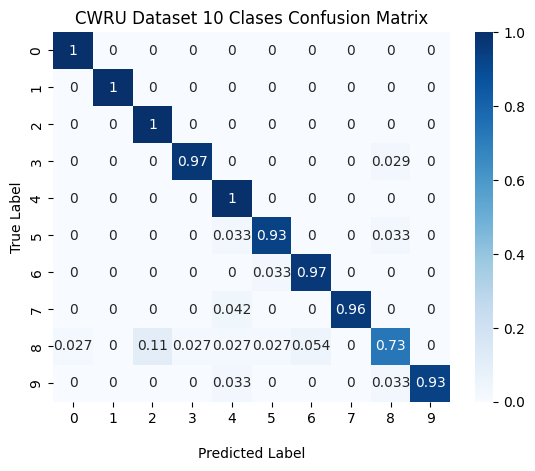

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [21]:

read_data = prepare_ZZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn =  tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 150,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

# Only MLP

Epoch 1/150
29/29 [==============================] - 1s 9ms/step - loss: 1.9096 - accuracy: 0.3768 - val_loss: 1.5133 - val_accuracy: 0.4439
Epoch 2/150
29/29 [==============================] - 0s 3ms/step - loss: 1.3271 - accuracy: 0.5520 - val_loss: 1.1354 - val_accuracy: 0.5867
Epoch 3/150
29/29 [==============================] - 0s 3ms/step - loss: 0.9811 - accuracy: 0.6769 - val_loss: 0.8424 - val_accuracy: 0.8240
Epoch 4/150
29/29 [==============================] - 0s 3ms/step - loss: 0.7471 - accuracy: 0.8160 - val_loss: 0.6855 - val_accuracy: 0.8342
Epoch 5/150
29/29 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.8456 - val_loss: 0.5621 - val_accuracy: 0.8827
Epoch 6/150
29/29 [==============================] - 0s 3ms/step - loss: 0.5257 - accuracy: 0.8806 - val_loss: 0.4995 - val_accuracy: 0.8827
Epoch 7/150
29/29 [==============================] - 0s 3ms/step - loss: 0.4595 - accuracy: 0.8850 - val_loss: 0.4580 - val_accuracy: 0.9209
Epoch 8/150
2

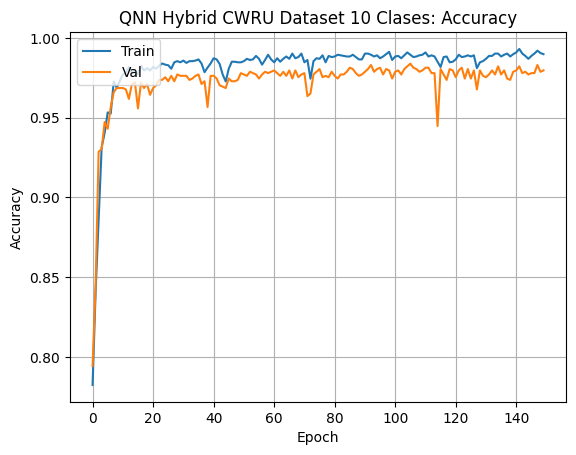

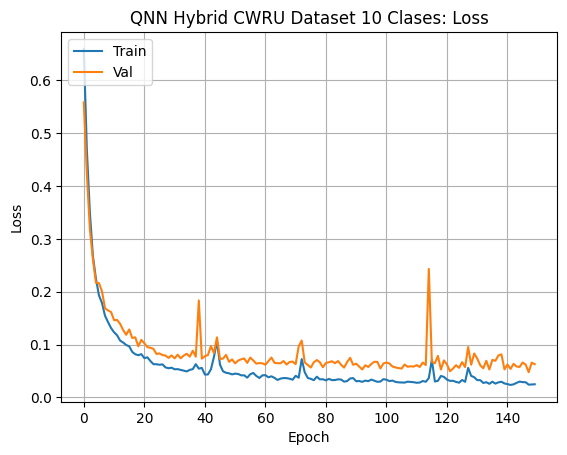

accuracy
[0.9857612252235413, 0.9923329949378967, 0.9912376999855042]
mean: 0.9897773067156473
devest: 0.0028747870265015173
val_accuracy
[0.9770408272743225, 0.9795918464660645, 0.9821428656578064]
mean: 0.9795918464660645
devest: 0.002082898447938308
loss
[0.03680914267897606, 0.02004760317504406, 0.018162637948989868]
mean: 0.025006461267669994
devest: 0.008381159022810256
val_loss
[0.06392966955900192, 0.053101979196071625, 0.07215146720409393]
mean: 0.06306103865305583
devest: 0.007801138296429139
f1 : [0.9770408163265306, 0.9795918367346939, 0.9821428571428571]
f1 average: 0.979591836734694
Precision : [0.9770408163265306, 0.9795918367346939, 0.9821428571428571]
precision average: 0.979591836734694
Recall : [0.9770408163265306, 0.9795918367346939, 0.9821428571428571]
recall average: 0.979591836734694
Accuracy : [0.9770408163265306, 0.9795918367346939, 0.9821428571428571]
accuracy average: 0.979591836734694
13/13 [==============================] - 0s 1ms/step - loss: 0.0722 - accu

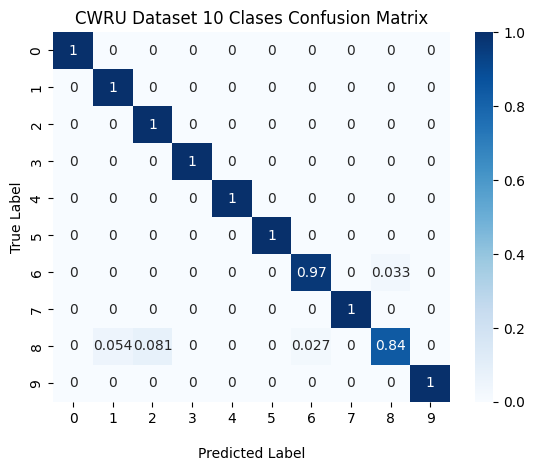

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1)
scaler = MinMaxScaler(feature_range = (0, 1))                                                  #o valor de cada característica é classificada como o angulo do qubit, portanto, em vez de normalizar entre 0 e 1, normalizamos entre 0 e pi
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)                                                                  #só o transform, se não vai contaminar os dados de teste
    
classes = len(np.unique(y))

y_train = np.eye(classes)[y_train]                                                                      #one hot encoder para otimizar, tem 3 características dos dados de treinamento (0, 1, 2 - modos de falha)
y_test = np.eye(classes)[y_test]

classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])

model = nn#tf.keras.Model(outputs = nn())

#print(model.summary())
list_models = []

# metrics
f1_list = []
precision_list = []
recall_list = []
accuracy_list = []
model_times = 3 
for i in range(model_times):
    model = nn#tf.keras.Model(inputs = nn(), outputs = nn() )
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history = model.fit(x = x_train, y = y_train, epochs = 150, verbose = 1, validation_data= (x_test,y_test) )
    list_models.append(history)

    y_pred = model.predict(x_test)
    f1_score = sklearn.metrics.f1_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
    precision_score = sklearn.metrics.precision_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
    recall_score = sklearn.metrics.recall_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
    accuracy_score = sklearn.metrics.accuracy_score(y_test.argmax( axis=1), y_pred.argmax( axis=1))
    f1_list.append( f1_score )
    precision_list.append( precision_score )
    recall_list.append( recall_score )
    accuracy_list.append( accuracy_score )

plot_history_list(list_models,name="QNN Hybrid {}".format(name_dataset) )

print("f1 :", f1_list)
print("f1 average:", np.mean(f1_list) )
print("Precision :", precision_list)
print("precision average:", np.mean(precision_list) )
print("Recall :", recall_list)
print("recall average:", np.mean(recall_list) )
print("Accuracy :", accuracy_list)
print("accuracy average:", np.mean(accuracy_list) )
model.evaluate(x_test, y_test)
cm = confusion_matrix(y_test.argmax( axis=1), y_pred.argmax( axis=1), normalize='true')

if classes == 3:  
    ax = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['No Damage', 'Outer Ring', 'Inner Ring'],yticklabels=['No Damage', 'Outer Ring', 'Inner Ring'],)
else:

    ax = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=range(classes),yticklabels=range(classes))

ax.set_title('{} Confusion Matrix'.format(name_dataset));
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label');
#plt.savefig('/content/{}_CM.png'.format(name_dataset))
plt.show()